In [1]:
!pip install scikit-learn==1.3.2
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, classification_report)
import matplotlib.pyplot as plt
import joblib #for saving the roc curve details
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.


In [2]:
# Load DT data (named features, no scaling/PCA)
train_path = '/kaggle/input/telco-train-test-split-dataset/train_dt.csv'
test_path = '/kaggle/input/telco-train-test-split-dataset/test_dt.csv'


In [3]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [4]:
X_train = df_train.drop('Churn', axis=1)
y_train = df_train['Churn']
X_test = df_test.drop('Churn', axis=1)
y_test = df_test['Churn']

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Class distribution in train: {y_train.value_counts()}")
print(f"Class distribution in test: {y_test.value_counts()}")
print("\nFeature names:", X_train.columns.tolist()[:10], "...")

Train shape: (5634, 34), Test shape: (1409, 34)
Class distribution in train: Churn
0    4139
1    1495
Name: count, dtype: int64
Class distribution in test: Churn
0    1035
1     374
Name: count, dtype: int64

Feature names: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'TotalServices'] ...


In [5]:
# ============================================================
# ENHANCED HYPERPARAMETER TUNING WITH CLASS WEIGHTS
# ============================================================

# Expanded parameter grid with more options
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, None],  # Added 15
    'min_samples_split': [2, 5, 10, 20],  # Added 20
    'min_samples_leaf': [1, 2, 4, 8],  # Added 8
    'max_features': ['sqrt', 'log2', None],  # NEW - feature sampling
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']  # CHANGED - only use balanced (handles imbalance)
}

print("\nStarting GridSearchCV with enhanced parameters...")
print(f"Total combinations to try: {len(param_grid_dt['max_depth']) * len(param_grid_dt['min_samples_split']) * len(param_grid_dt['min_samples_leaf']) * len(param_grid_dt['max_features']) * len(param_grid_dt['criterion']) * len(param_grid_dt['class_weight'])}")


Starting GridSearchCV with enhanced parameters...
Total combinations to try: 576


In [6]:
dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(
    dt, 
    param_grid_dt, 
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1 score (good for imbalanced data)
    n_jobs=-1,  # Use all CPU cores
    verbose=2  # Show progress
)

grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 15, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=2)

In [7]:
# ============================================================
# BEST MODEL AND RESULTS
# ============================================================

best_dt = grid_dt.best_estimator_
print("\n" + "="*60)
print("BEST MODEL FOUND")
print("="*60)
print(f"Best Parameters: {grid_dt.best_params_}")
print(f"Best CV F1 Score: {grid_dt.best_score_:.4f}")
print("="*60)


BEST MODEL FOUND
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}
Best CV F1 Score: 0.6159


In [8]:
# ============================================================
# PREDICTIONS AND EVALUATION
# ============================================================

# Predictions on test set
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

In [9]:
# Calculate metrics
metrics_dt = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1-Score': f1_score(y_test, y_pred_dt),
    'ROC-AUC': roc_auc_score(y_test, y_prob_dt)
}

print("\n" + "="*60)
print("TEST SET METRICS")
print("="*60)
for metric, value in metrics_dt.items():
    print(f"{metric:12s}: {value:.4f}")
print("="*60)


TEST SET METRICS
Accuracy    : 0.7374
Precision   : 0.5034
Recall      : 0.7941
F1-Score    : 0.6162
ROC-AUC     : 0.8286


In [10]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))


Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.80      1035
       Churn       0.50      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [11]:
# Save metrics table
pd.DataFrame(list(metrics_dt.items()), columns=['Metric', 'Value']).to_csv(
    '/kaggle/working/dt_metrics.csv', index=False
)

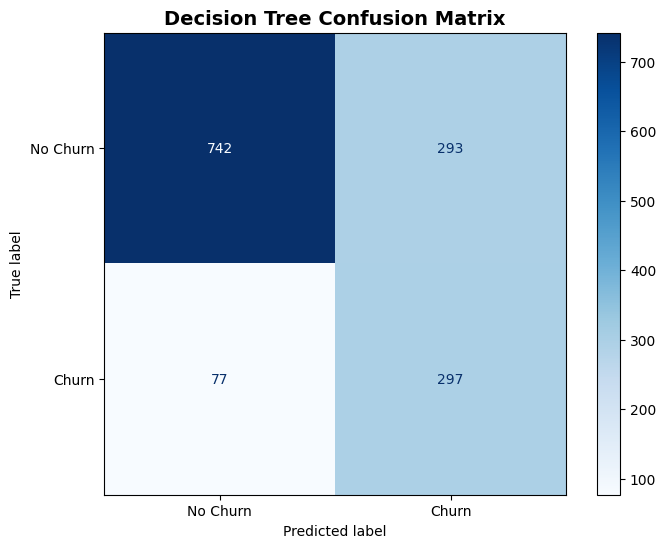

In [12]:
# ============================================================
# VISUALIZATIONS
# ============================================================

# 1. Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues', ax=ax)
plt.title('Decision Tree Confusion Matrix', fontsize=14, fontweight='bold')
plt.savefig('/kaggle/working/dt_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

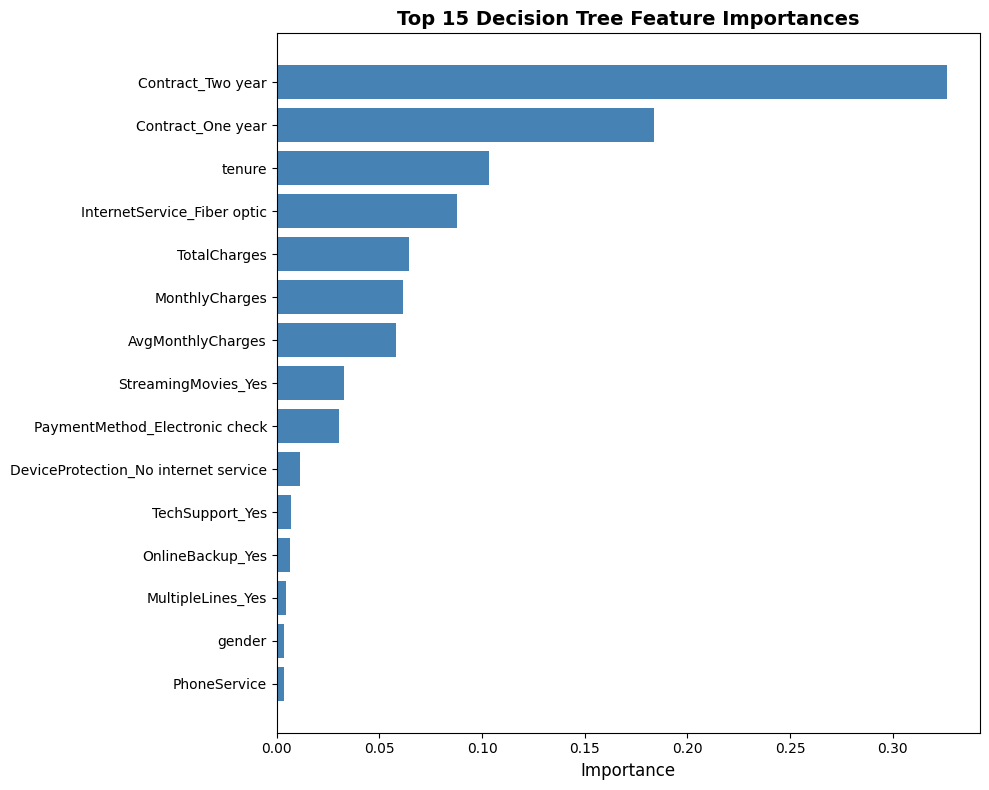

In [13]:
# 2. Feature Importances (Top 15)
importances = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': best_dt.feature_importances_
})
importances = importances.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances['Importance'], color='steelblue')
plt.yticks(range(len(importances)), importances['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Decision Tree Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/kaggle/working/dt_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Print top features
print("\nTop 10 Most Important Features:")
for i, (feat, imp) in enumerate(zip(importances['Feature'].head(10), 
                                     importances['Importance'].head(10)), 1):
    print(f"{i:2d}. {feat:30s}: {imp:.4f}")


Top 10 Most Important Features:
 1. Contract_Two year             : 0.3262
 2. Contract_One year             : 0.1836
 3. tenure                        : 0.1036
 4. InternetService_Fiber optic   : 0.0877
 5. TotalCharges                  : 0.0643
 6. MonthlyCharges                : 0.0614
 7. AvgMonthlyCharges             : 0.0582
 8. StreamingMovies_Yes           : 0.0326
 9. PaymentMethod_Electronic check: 0.0302
10. DeviceProtection_No internet service: 0.0115


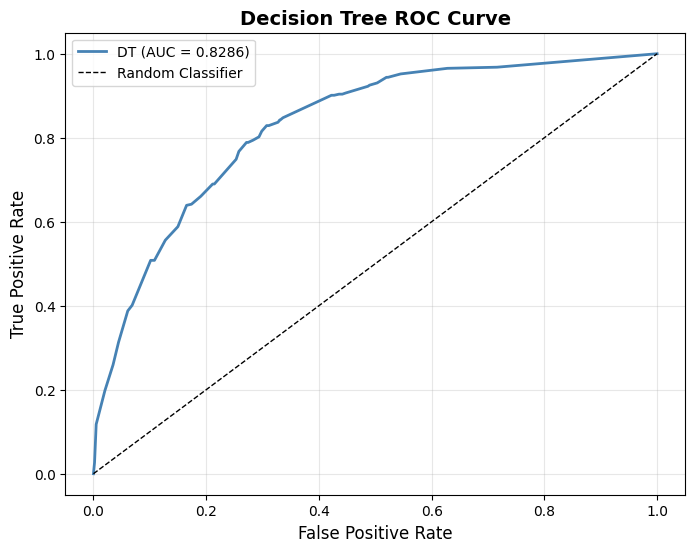

In [15]:
# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'DT (AUC = {metrics_dt["ROC-AUC"]:.4f})', linewidth=2, color='steelblue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Decision Tree ROC Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.savefig('/kaggle/working/dt_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Save the best Decision Tree model
joblib.dump(grid_dt.best_estimator_, '/kaggle/working/best_decision_tree.pkl')

# Save test probabilities + true labels (for comparison later)
joblib.dump({
    'y_true':       y_test,
    'y_pred_proba': grid_dt.best_estimator_.predict_proba(X_test)[:, 1],
    'y_pred':       grid_dt.best_estimator_.predict(X_test)
}, '/kaggle/working/dt_results.pkl')

print("Decision Tree model and predictions saved to Kaggle Output!")

Decision Tree model and predictions saved to Kaggle Output!
